## Define the Convolutional Neural Network

After you've looked at the data you're working with and, in this case, know the shapes of the images and of the keypoints, you are ready to define a convolutional neural network that can *learn* from this data.

In this notebook and in `models.py`, you will:
1. Define a CNN with images as input and keypoints as output
2. Construct the transformed FaceKeypointsDataset, just as before
3. Train the CNN on the training data, tracking loss
4. See how the trained model performs on test data
5. If necessary, modify the CNN structure and model hyperparameters, so that it performs *well* **\***

**\*** What does *well* mean?

"Well" means that the model's loss decreases during training **and**, when applied to test image data, the model produces keypoints that closely match the true keypoints of each face. And you'll see examples of this later in the notebook.

---


## CNN Architecture

Recall that CNN's are defined by a few types of layers:
* Convolutional layers
* Maxpooling layers
* Fully-connected layers

You are required to use the above layers and encouraged to add multiple convolutional layers and things like dropout layers that may prevent overfitting. You are also encouraged to look at literature on keypoint detection, such as [this paper](https://arxiv.org/pdf/1710.00977.pdf), to help you determine the structure of your network.


### TODO: Define your model in the provided file `models.py` file

This file is mostly empty but contains the expected name and some TODO's for creating your model.

---

## PyTorch Neural Nets

To define a neural network in PyTorch, you define the layers of a model in the function `__init__` and define the feedforward behavior of a network that employs those initialized layers in the function `forward`, which takes in an input image tensor, `x`. The structure of this Net class is shown below and left for you to fill in.

Note: During training, PyTorch will be able to perform backpropagation by keeping track of the network's feedforward behavior and using autograd to calculate the update to the weights in the network.

#### Define the Layers in ` __init__`
As a reminder, a conv/pool layer may be defined like this (in `__init__`):
```
# 1 input image channel (for grayscale images), 32 output channels/feature maps, 3x3 square convolution kernel
self.conv1 = nn.Conv2d(1, 32, 3)

# maxpool that uses a square window of kernel_size=2, stride=2
self.pool = nn.MaxPool2d(2, 2)      
```

#### Refer to Layers in `forward`
Then referred to in the `forward` function like this, in which the conv1 layer has a ReLu activation applied to it before maxpooling is applied:
```
x = self.pool(F.relu(self.conv1(x)))
```

Best practice is to place any layers whose weights will change during the training process in `__init__` and refer to them in the `forward` function; any layers or functions that always behave in the same way, such as a pre-defined activation function, should appear *only* in the `forward` function.

#### Why models.py

You are tasked with defining the network in the `models.py` file so that any models you define can be saved and loaded by name in different notebooks in this project directory. For example, by defining a CNN class called `Net` in `models.py`, you can then create that same architecture in this and other notebooks by simply importing the class and instantiating a model:
```
    from models import Net
    net = Net()
```

In [2]:
# load the data if you need to; if you have already loaded the data, you may comment this cell out
# -- DO NOT CHANGE THIS CELL -- #
!mkdir /data
!wget -P /data/ https://s3.amazonaws.com/video.udacity-data.com/topher/2018/May/5aea1b91_train-test-data/train-test-data.zip
!unzip -n /data/train-test-data.zip -d /data

The syntax of the command is incorrect.
'wget' is not recognized as an internal or external command,
operable program or batch file.
'unzip' is not recognized as an internal or external command,
operable program or batch file.


<div class="alert alert-info">**Note:** Workspaces automatically close connections after 30 minutes of inactivity (including inactivity while training!). Use the code snippet below to keep your workspace alive during training. (The active_session context manager is imported below.)
</div>
```
from workspace_utils import active_session

with active_session():
    train_model(num_epochs)
```


In [103]:
%reset
# import the usual resources
import matplotlib.pyplot as plt
import numpy as np

# import utilities to keep workspaces alive during model training
from workspace_utils import active_session

# watch for any changes in model.py, if it changes, re-load it automatically
%load_ext autoreload
%autoreload 2

Once deleted, variables cannot be recovered. Proceed (y/[n])? y
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [105]:
## TODO: Define the Net in models.py

import torch
import torch.nn as nn
import torch.nn.functional as F

## TODO: Once you've define the network, you can instantiate it
# one example conv layer has been provided for you
from models import Net
#torch.backends.cudnn.enabled = True
#torch.backends.cudnn.benchmark = True
net = Net()
if torch.cuda.is_available():
    net = net.cuda()
print(net)
print(torch.cuda.is_available())

Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (activation1): ReLU()
  (pooling1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (activation2): ReLU()
  (pooling2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (activation3): ReLU()
  (pooling3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (activation4): ReLU()
  (pooling4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv5): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (activation5): ReLU()
  (pooling5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv6): Conv2d(512, 1024, kernel_size=

## Transform the dataset 

To prepare for training, create a transformed dataset of images and keypoints.

### TODO: Define a data transform

In PyTorch, a convolutional neural network expects a torch image of a consistent size as input. For efficient training, and so your model's loss does not blow up during training, it is also suggested that you normalize the input images and keypoints. The necessary transforms have been defined in `data_load.py` and you **do not** need to modify these; take a look at this file (you'll see the same transforms that were defined and applied in Notebook 1).

To define the data transform below, use a [composition](http://pytorch.org/tutorials/beginner/data_loading_tutorial.html#compose-transforms) of:
1. Rescaling and/or cropping the data, such that you are left with a square image (the suggested size is 224x224px)
2. Normalizing the images and keypoints; turning each RGB image into a grayscale image with a color range of [0, 1] and transforming the given keypoints into a range of [-1, 1]
3. Turning these images and keypoints into Tensors

These transformations have been defined in `data_load.py`, but it's up to you to call them and create a `data_transform` below. **This transform will be applied to the training data and, later, the test data**. It will change how you go about displaying these images and keypoints, but these steps are essential for efficient training.

As a note, should you want to perform data augmentation (which is optional in this project), and randomly rotate or shift these images, a square image size will be useful; rotating a 224x224 image by 90 degrees will result in the same shape of output.

In [106]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# the dataset we created in Notebook 1 is copied in the helper file `data_load.py`
from data_load import FacialKeypointsDataset
# the transforms we defined in Notebook 1 are in the helper file `data_load.py`
from data_load import Rescale, RandomCrop, Normalize, ToTensor


## TODO: define the data_transform using transforms.Compose([all tx's, . , .])
# order matters! i.e. rescaling should come before a smaller crop
#data_transform = transforms.Compose([ToTensor()])
data_transform = transforms.Compose([Rescale(250),
                                     RandomCrop(224),
                                     Normalize(),
                                     ToTensor()])

# testing that you've defined a transform
assert(data_transform is not None), 'Define a data_transform'

In [107]:
# create the transformed dataset
transformed_dataset = FacialKeypointsDataset(csv_file='./data/training_frames_keypoints.csv',
                                             root_dir='./data/training/',
                                             transform=data_transform)


print('Number of images: ', len(transformed_dataset))

# iterate through the transformed dataset and print some stats about the first few samples
print((transformed_dataset[0]['image'].size()))
for i in range(4):
    sample = transformed_dataset[i]
    print(i, sample['image'].size(), sample['keypoints'].size())

Number of images:  3462
torch.Size([1, 224, 224])
0 torch.Size([1, 224, 224]) torch.Size([68, 2])
1 torch.Size([1, 224, 224]) torch.Size([68, 2])
2 torch.Size([1, 224, 224]) torch.Size([68, 2])
3 torch.Size([1, 224, 224]) torch.Size([68, 2])


## Batching and loading data

Next, having defined the transformed dataset, we can use PyTorch's DataLoader class to load the training data in batches of whatever size as well as to shuffle the data for training the model. You can read more about the parameters of the DataLoader, in [this documentation](http://pytorch.org/docs/master/data.html).

#### Batch size
Decide on a good batch size for training your model. Try both small and large batch sizes and note how the loss decreases as the model trains. Too large a batch size may cause your model to crash and/or run out of memory while training.

**Note for Windows users**: Please change the `num_workers` to 0 or you may face some issues with your DataLoader failing.

In [108]:
# load training data in batches
batch_size = 32

train_loader = DataLoader(transformed_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=0)


## Before training

Take a look at how this model performs before it trains. You should see that the keypoints it predicts start off in one spot and don't match the keypoints on a face at all! It's interesting to visualize this behavior so that you can compare it to the model after training and see how the model has improved.

#### Load in the test dataset

The test dataset is one that this model has *not* seen before, meaning it has not trained with these images. We'll load in this test data and before and after training, see how your model performs on this set!

To visualize this test data, we have to go through some un-transformation steps to turn our images into python images from tensors and to turn our keypoints back into a recognizable range. 

In [109]:
# load in the test data, using the dataset class
# AND apply the data_transform you defined above

# create the test dataset
test_dataset = FacialKeypointsDataset(csv_file='./data/test_frames_keypoints.csv',
                                             root_dir='./data/test/',
                                             transform=data_transform)



In [110]:
# load test data in batches
batch_size = 10

test_loader = DataLoader(test_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=0)

## Apply the model on a test sample

To test the model on a test sample of data, you have to follow these steps:
1. Extract the image and ground truth keypoints from a sample
2. Wrap the image in a Variable, so that the net can process it as input and track how it changes as the image moves through the network.
3. Make sure the image is a FloatTensor, which the model expects.
4. Forward pass the image through the net to get the predicted, output keypoints.

This function test how the network performs on the first batch of test data. It returns the images, the transformed images, the predicted keypoints (produced by the model), and the ground truth keypoints.

In [111]:
# test the model on a batch of test images

def net_sample_output():
    
    # iterate through the test dataset
    for i, sample in enumerate(test_loader):
        
        # get sample data: images and ground truth keypoints
        images = sample['image']
        key_pts = sample['keypoints']

        # convert images to FloatTensors
        images = images.type(torch.FloatTensor)

        if torch.cuda.is_available():
            images = images.cuda()
            key_pts = key_pts.cuda()

        # forward pass to get net output
        output_pts = net(images)
        
        if torch.cuda.is_available():
            output_pts = output_pts.cpu()
        
        # reshape to batch_size x 68 x 2 pts
        output_pts = output_pts.view(output_pts.size()[0], 68, -1)
        
        # break after first image is tested
        if i == 0:
            return images, output_pts, key_pts
            

#### Debugging tips

If you get a size or dimension error here, make sure that your network outputs the expected number of keypoints! Or if you get a Tensor type error, look into changing the above code that casts the data into float types: `images = images.type(torch.FloatTensor)`.

In [112]:
# call the above function
# returns: test images, test predicted keypoints, test ground truth keypoints
test_images, test_outputs, gt_pts = net_sample_output()

if torch.cuda.is_available():
    test_images = test_images.cpu()
    test_outputs = test_outputs.cpu()
    gt_pts = gt_pts.cpu()

# print out the dimensions of the data to see if they make sense
print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

torch.Size([10, 1, 224, 224])
torch.Size([10, 68, 2])
torch.Size([10, 68, 2])


## Visualize the predicted keypoints

Once we've had the model produce some predicted output keypoints, we can visualize these points in a way that's similar to how we've displayed this data before, only this time, we have to "un-transform" the image/keypoint data to display it.

Note that I've defined a *new* function, `show_all_keypoints` that displays a grayscale image, its predicted keypoints and its ground truth keypoints (if provided).

In [113]:
def show_all_keypoints(image, predicted_key_pts, gt_pts=None):
    """Show image with predicted keypoints"""
    # image is grayscale
    plt.imshow(image, cmap='gray')
    plt.scatter(predicted_key_pts[:, 0], predicted_key_pts[:, 1], s=20, marker='.', c='m')
    # plot ground truth points as green pts
    if gt_pts is not None:
        plt.scatter(gt_pts[:, 0], gt_pts[:, 1], s=20, marker='.', c='g')


#### Un-transformation

Next, you'll see a helper function. `visualize_output` that takes in a batch of images, predicted keypoints, and ground truth keypoints and displays a set of those images and their true/predicted keypoints.

This function's main role is to take batches of image and keypoint data (the input and output of your CNN), and transform them into numpy images and un-normalized keypoints (x, y) for normal display. The un-transformation process turns keypoints and images into numpy arrays from Tensors *and* it undoes the keypoint normalization done in the Normalize() transform; it's assumed that you applied these transformations when you loaded your test data.

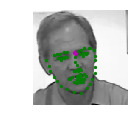

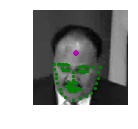

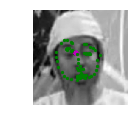

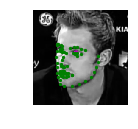

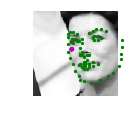

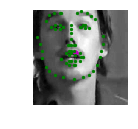

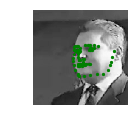

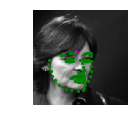

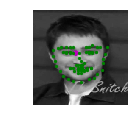

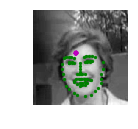

In [114]:
# visualize the output
# by default this shows a batch of 10 images
def visualize_output(test_images, test_outputs, gt_pts=None, batch_size=10):

    for i in range(batch_size):
        plt.figure(figsize=(20,10))
        ax = plt.subplot(1, batch_size, i+1)

        # un-transform the image data
        image = test_images[i].data   # get the image from it's Variable wrapper
        image = image.numpy()   # convert to numpy array from a Tensor
        image = np.transpose(image, (1, 2, 0))   # transpose to go from torch to numpy image

        # un-transform the predicted key_pts data
        predicted_key_pts = test_outputs[i].data
        predicted_key_pts = predicted_key_pts.numpy()
        # undo normalization of keypoints  
        predicted_key_pts = predicted_key_pts*50.0+100
        
        # plot ground truth points for comparison, if they exist
        ground_truth_pts = None
        if gt_pts is not None:
            ground_truth_pts = gt_pts[i]         
            ground_truth_pts = ground_truth_pts*50.0+100
        
        # call show_all_keypoints
        show_all_keypoints(np.squeeze(image), predicted_key_pts, ground_truth_pts)
            
        plt.axis('off')

    plt.show()
    
# call it
visualize_output(test_images, test_outputs, gt_pts)

## Training

#### Loss function
Training a network to predict keypoints is different than training a network to predict a class; instead of outputting a distribution of classes and using cross entropy loss, you may want to choose a loss function that is suited for regression, which directly compares a predicted value and target value. Read about the various kinds of loss functions (like MSE or L1/SmoothL1 loss) in [this documentation](http://pytorch.org/docs/master/_modules/torch/nn/modules/loss.html).

### TODO: Define the loss and optimization

Next, you'll define how the model will train by deciding on the loss function and optimizer.

---

In [115]:
## TODO: Define the loss and optimization
import torch.optim as optim

criterion = nn.MSELoss()

optimizer = optim.Adam(net.parameters(), lr = 0.001)



## Training and Initial Observation

Now, you'll train on your batched training data from `train_loader` for a number of epochs. 

To quickly observe how your model is training and decide on whether or not you should modify it's structure or hyperparameters, you're encouraged to start off with just one or two epochs at first. As you train, note how your the model's loss behaves over time: does it decrease quickly at first and then slow down? Does it take a while to decrease in the first place? What happens if you change the batch size of your training data or modify your loss function? etc. 

Use these initial observations to make changes to your model and decide on the best architecture before you train for many epochs and create a final model.

In [116]:
def train_net(n_epochs):

    # prepare the net for training
    net.train()

    for epoch in range(n_epochs):  # loop over the dataset multiple times
        
        running_loss = 0.0

        # train on batches of data, assumes you already have train_loader
        for batch_i, data in enumerate(train_loader):
            # get the input images and their corresponding labels
            images = data['image']
            key_pts = data['keypoints']

            # flatten pts
            key_pts = key_pts.view(key_pts.size(0), -1)

            # convert variables to floats for regression loss
            key_pts = key_pts.type(torch.FloatTensor)
            images = images.type(torch.FloatTensor)

            if torch.cuda.is_available():            
                images = images.cuda()
                key_pts = key_pts.cuda()

            # forward pass to get outputs
            output_pts = net(images)

            # calculate the loss between predicted and target keypoints
            loss = criterion(output_pts, key_pts)

            # zero the parameter (weight) gradients
            optimizer.zero_grad()
            
            # backward pass to calculate the weight gradients
            loss.backward()

            # update the weights
            optimizer.step()

            # print loss statistics
            running_loss += loss.item()
            if batch_i % 10 == 9:    # print every 10 batches
                print('Epoch: {}, Batch: {}, Avg. Loss: {}'.format(epoch + 1, batch_i+1, running_loss/10))
                running_loss = 0.0

    print('Finished Training')


In [117]:
# train your network
n_epochs = 250 # start small, and increase when you've decided on your model structure and hyperparams
print(torch.__version__)
# this is a Workspaces-specific context manager to keep the connection
# alive while training your model, not part of pytorch
#with active_session():
train_net(n_epochs)

0.4.1
Epoch: 1, Batch: 10, Avg. Loss: 1.3706292420625688
Epoch: 1, Batch: 20, Avg. Loss: 0.3692572474479675
Epoch: 1, Batch: 30, Avg. Loss: 0.21108190715312958
Epoch: 1, Batch: 40, Avg. Loss: 0.1790890537202358
Epoch: 1, Batch: 50, Avg. Loss: 0.18587537258863449
Epoch: 1, Batch: 60, Avg. Loss: 0.18462107032537461
Epoch: 1, Batch: 70, Avg. Loss: 0.17910783886909484
Epoch: 1, Batch: 80, Avg. Loss: 0.18550674691796304
Epoch: 1, Batch: 90, Avg. Loss: 0.16209365651011468
Epoch: 1, Batch: 100, Avg. Loss: 0.18559838682413102
Epoch: 2, Batch: 10, Avg. Loss: 0.19036918729543686
Epoch: 2, Batch: 20, Avg. Loss: 0.19762373268604277
Epoch: 2, Batch: 30, Avg. Loss: 0.2014853149652481
Epoch: 2, Batch: 40, Avg. Loss: 0.21924554258584977
Epoch: 2, Batch: 50, Avg. Loss: 0.20911891460418702
Epoch: 2, Batch: 60, Avg. Loss: 0.19622821509838104
Epoch: 2, Batch: 70, Avg. Loss: 0.16812826246023177
Epoch: 2, Batch: 80, Avg. Loss: 0.19965000599622726
Epoch: 2, Batch: 90, Avg. Loss: 0.20125316083431244
Epoch: 2,

Epoch: 16, Batch: 60, Avg. Loss: 0.04735874030739069
Epoch: 16, Batch: 70, Avg. Loss: 0.030457369238138198
Epoch: 16, Batch: 80, Avg. Loss: 0.02621691655367613
Epoch: 16, Batch: 90, Avg. Loss: 0.0420989578589797
Epoch: 16, Batch: 100, Avg. Loss: 0.033606598153710365
Epoch: 17, Batch: 10, Avg. Loss: 0.022736299969255924
Epoch: 17, Batch: 20, Avg. Loss: 0.02234564982354641
Epoch: 17, Batch: 30, Avg. Loss: 0.037012694776058196
Epoch: 17, Batch: 40, Avg. Loss: 0.023889390006661414
Epoch: 17, Batch: 50, Avg. Loss: 0.02182250823825598
Epoch: 17, Batch: 60, Avg. Loss: 0.02101639434695244
Epoch: 17, Batch: 70, Avg. Loss: 0.019954699836671353
Epoch: 17, Batch: 80, Avg. Loss: 0.022550420463085176
Epoch: 17, Batch: 90, Avg. Loss: 0.02005334347486496
Epoch: 17, Batch: 100, Avg. Loss: 0.0445957294665277
Epoch: 18, Batch: 10, Avg. Loss: 0.019018775131553412
Epoch: 18, Batch: 20, Avg. Loss: 0.014615492150187492
Epoch: 18, Batch: 30, Avg. Loss: 0.019130564853549005
Epoch: 18, Batch: 40, Avg. Loss: 0.0

Epoch: 31, Batch: 80, Avg. Loss: 0.019337276555597784
Epoch: 31, Batch: 90, Avg. Loss: 0.033428095281124115
Epoch: 31, Batch: 100, Avg. Loss: 0.019787287153303624
Epoch: 32, Batch: 10, Avg. Loss: 0.07917988719418645
Epoch: 32, Batch: 20, Avg. Loss: 0.019340914953500033
Epoch: 32, Batch: 30, Avg. Loss: 0.020705293212085963
Epoch: 32, Batch: 40, Avg. Loss: 0.014984881225973367
Epoch: 32, Batch: 50, Avg. Loss: 0.012843278469517827
Epoch: 32, Batch: 60, Avg. Loss: 0.014053821191191673
Epoch: 32, Batch: 70, Avg. Loss: 0.012042597308754921
Epoch: 32, Batch: 80, Avg. Loss: 0.026703254785388708
Epoch: 32, Batch: 90, Avg. Loss: 0.011751209571957588
Epoch: 32, Batch: 100, Avg. Loss: 0.013204876333475113
Epoch: 33, Batch: 10, Avg. Loss: 0.010735311452299357
Epoch: 33, Batch: 20, Avg. Loss: 0.013008055835962295
Epoch: 33, Batch: 30, Avg. Loss: 0.01574382549151778
Epoch: 33, Batch: 40, Avg. Loss: 0.013555886317044496
Epoch: 33, Batch: 50, Avg. Loss: 0.010379704087972641
Epoch: 33, Batch: 60, Avg. L

Epoch: 46, Batch: 100, Avg. Loss: 0.008071461785584688
Epoch: 47, Batch: 10, Avg. Loss: 0.0076933698263019325
Epoch: 47, Batch: 20, Avg. Loss: 0.008796913782134652
Epoch: 47, Batch: 30, Avg. Loss: 0.013718531094491481
Epoch: 47, Batch: 40, Avg. Loss: 0.03422596249729395
Epoch: 47, Batch: 50, Avg. Loss: 0.011331306863576173
Epoch: 47, Batch: 60, Avg. Loss: 0.011925496999174357
Epoch: 47, Batch: 70, Avg. Loss: 0.01365379812195897
Epoch: 47, Batch: 80, Avg. Loss: 0.010424565197899938
Epoch: 47, Batch: 90, Avg. Loss: 0.013916794583201409
Epoch: 47, Batch: 100, Avg. Loss: 0.011077622137963771
Epoch: 48, Batch: 10, Avg. Loss: 0.009107546415179968
Epoch: 48, Batch: 20, Avg. Loss: 0.010492923483252526
Epoch: 48, Batch: 30, Avg. Loss: 0.008007451565936208
Epoch: 48, Batch: 40, Avg. Loss: 0.007663829810917377
Epoch: 48, Batch: 50, Avg. Loss: 0.007705877861008048
Epoch: 48, Batch: 60, Avg. Loss: 0.0082621353212744
Epoch: 48, Batch: 70, Avg. Loss: 0.009471334889531136
Epoch: 48, Batch: 80, Avg. Lo

Epoch: 62, Batch: 20, Avg. Loss: 0.007330869371071458
Epoch: 62, Batch: 30, Avg. Loss: 0.006891813222318887
Epoch: 62, Batch: 40, Avg. Loss: 0.011550751514732838
Epoch: 62, Batch: 50, Avg. Loss: 0.007534069707617164
Epoch: 62, Batch: 60, Avg. Loss: 0.006895077368244529
Epoch: 62, Batch: 70, Avg. Loss: 0.008556257095187902
Epoch: 62, Batch: 80, Avg. Loss: 0.008122685831040144
Epoch: 62, Batch: 90, Avg. Loss: 0.018889749329537152
Epoch: 62, Batch: 100, Avg. Loss: 0.007884024316444993
Epoch: 63, Batch: 10, Avg. Loss: 0.009399607544764876
Epoch: 63, Batch: 20, Avg. Loss: 0.013458149461075663
Epoch: 63, Batch: 30, Avg. Loss: 0.007856370089575649
Epoch: 63, Batch: 40, Avg. Loss: 0.01304819849319756
Epoch: 63, Batch: 50, Avg. Loss: 0.009468969004228712
Epoch: 63, Batch: 60, Avg. Loss: 0.007689765701070428
Epoch: 63, Batch: 70, Avg. Loss: 0.007844404364004732
Epoch: 63, Batch: 80, Avg. Loss: 0.007592411013320088
Epoch: 63, Batch: 90, Avg. Loss: 0.007491896487772464
Epoch: 63, Batch: 100, Avg. 

Epoch: 77, Batch: 30, Avg. Loss: 0.011789403762668372
Epoch: 77, Batch: 40, Avg. Loss: 0.010145842004567385
Epoch: 77, Batch: 50, Avg. Loss: 0.012481518648564815
Epoch: 77, Batch: 60, Avg. Loss: 0.011670223157852887
Epoch: 77, Batch: 70, Avg. Loss: 0.009206476621329784
Epoch: 77, Batch: 80, Avg. Loss: 0.007712853746488691
Epoch: 77, Batch: 90, Avg. Loss: 0.007290770672261715
Epoch: 77, Batch: 100, Avg. Loss: 0.0073234009556472305
Epoch: 78, Batch: 10, Avg. Loss: 0.017655101092532276
Epoch: 78, Batch: 20, Avg. Loss: 0.0066300769802182915
Epoch: 78, Batch: 30, Avg. Loss: 0.008604377415031195
Epoch: 78, Batch: 40, Avg. Loss: 0.007343859737738967
Epoch: 78, Batch: 50, Avg. Loss: 0.041383739979937675
Epoch: 78, Batch: 60, Avg. Loss: 0.010431496752426028
Epoch: 78, Batch: 70, Avg. Loss: 0.012644272670149804
Epoch: 78, Batch: 80, Avg. Loss: 0.01119522931985557
Epoch: 78, Batch: 90, Avg. Loss: 0.008701733825728298
Epoch: 78, Batch: 100, Avg. Loss: 0.00922487946227193
Epoch: 79, Batch: 10, Avg.

Epoch: 92, Batch: 50, Avg. Loss: 0.006557868933305145
Epoch: 92, Batch: 60, Avg. Loss: 0.017460898123681547
Epoch: 92, Batch: 70, Avg. Loss: 0.006129481410607695
Epoch: 92, Batch: 80, Avg. Loss: 0.00927045801654458
Epoch: 92, Batch: 90, Avg. Loss: 0.011851340346038342
Epoch: 92, Batch: 100, Avg. Loss: 0.010308826714754105
Epoch: 93, Batch: 10, Avg. Loss: 0.008567423792555928
Epoch: 93, Batch: 20, Avg. Loss: 0.006972667016088963
Epoch: 93, Batch: 30, Avg. Loss: 0.00664251260459423
Epoch: 93, Batch: 40, Avg. Loss: 0.009913938818499446
Epoch: 93, Batch: 50, Avg. Loss: 0.006807057280093431
Epoch: 93, Batch: 60, Avg. Loss: 0.007023073593154549
Epoch: 93, Batch: 70, Avg. Loss: 0.006086443969979882
Epoch: 93, Batch: 80, Avg. Loss: 0.005785608198493719
Epoch: 93, Batch: 90, Avg. Loss: 0.008063639095053077
Epoch: 93, Batch: 100, Avg. Loss: 0.00686233532615006
Epoch: 94, Batch: 10, Avg. Loss: 0.006651677470654249
Epoch: 94, Batch: 20, Avg. Loss: 0.006493409397080541
Epoch: 94, Batch: 30, Avg. Lo

Epoch: 107, Batch: 50, Avg. Loss: 0.012419576244428753
Epoch: 107, Batch: 60, Avg. Loss: 0.01072192406281829
Epoch: 107, Batch: 70, Avg. Loss: 0.0074727293103933334
Epoch: 107, Batch: 80, Avg. Loss: 0.00689952690154314
Epoch: 107, Batch: 90, Avg. Loss: 0.006636499566957355
Epoch: 107, Batch: 100, Avg. Loss: 0.007388925366103649
Epoch: 108, Batch: 10, Avg. Loss: 0.006667012581601739
Epoch: 108, Batch: 20, Avg. Loss: 0.006592114921659231
Epoch: 108, Batch: 30, Avg. Loss: 0.00692727486602962
Epoch: 108, Batch: 40, Avg. Loss: 0.006730943825095892
Epoch: 108, Batch: 50, Avg. Loss: 0.008285843534395099
Epoch: 108, Batch: 60, Avg. Loss: 0.007775423396378755
Epoch: 108, Batch: 70, Avg. Loss: 0.006247445847839117
Epoch: 108, Batch: 80, Avg. Loss: 0.017887639161199332
Epoch: 108, Batch: 90, Avg. Loss: 0.008933920413255692
Epoch: 108, Batch: 100, Avg. Loss: 0.00859917770139873
Epoch: 109, Batch: 10, Avg. Loss: 0.0065723133739084005
Epoch: 109, Batch: 20, Avg. Loss: 0.006859671650454402
Epoch: 109

Epoch: 122, Batch: 30, Avg. Loss: 0.007663552742451429
Epoch: 122, Batch: 40, Avg. Loss: 0.006803375342860818
Epoch: 122, Batch: 50, Avg. Loss: 0.006891028955578804
Epoch: 122, Batch: 60, Avg. Loss: 0.008349306788295508
Epoch: 122, Batch: 70, Avg. Loss: 0.0062786942347884175
Epoch: 122, Batch: 80, Avg. Loss: 0.020189773896709083
Epoch: 122, Batch: 90, Avg. Loss: 0.025626495014876127
Epoch: 122, Batch: 100, Avg. Loss: 0.011857660859823227
Epoch: 123, Batch: 10, Avg. Loss: 0.010735456040129066
Epoch: 123, Batch: 20, Avg. Loss: 0.008262191200628877
Epoch: 123, Batch: 30, Avg. Loss: 0.006982597149908542
Epoch: 123, Batch: 40, Avg. Loss: 0.0070746195502579216
Epoch: 123, Batch: 50, Avg. Loss: 0.007653937814757228
Epoch: 123, Batch: 60, Avg. Loss: 0.011101582227274776
Epoch: 123, Batch: 70, Avg. Loss: 0.010610343655571342
Epoch: 123, Batch: 80, Avg. Loss: 0.007505509024485946
Epoch: 123, Batch: 90, Avg. Loss: 0.008442127471789717
Epoch: 123, Batch: 100, Avg. Loss: 0.011653927573934197
Epoch:

Epoch: 137, Batch: 20, Avg. Loss: 0.016395173827186228
Epoch: 137, Batch: 30, Avg. Loss: 0.007897999184206129
Epoch: 137, Batch: 40, Avg. Loss: 0.009159313468262553
Epoch: 137, Batch: 50, Avg. Loss: 0.010144941974431276
Epoch: 137, Batch: 60, Avg. Loss: 0.009983005002140999
Epoch: 137, Batch: 70, Avg. Loss: 0.007445347867906094
Epoch: 137, Batch: 80, Avg. Loss: 0.005845134146511555
Epoch: 137, Batch: 90, Avg. Loss: 0.00716597274877131
Epoch: 137, Batch: 100, Avg. Loss: 0.007314995443448424
Epoch: 138, Batch: 10, Avg. Loss: 0.0074768073856830595
Epoch: 138, Batch: 20, Avg. Loss: 0.00626055970788002
Epoch: 138, Batch: 30, Avg. Loss: 0.007417297596111894
Epoch: 138, Batch: 40, Avg. Loss: 0.006252336269244552
Epoch: 138, Batch: 50, Avg. Loss: 0.006380081130191684
Epoch: 138, Batch: 60, Avg. Loss: 0.007370034651830793
Epoch: 138, Batch: 70, Avg. Loss: 0.014391628839075566
Epoch: 138, Batch: 80, Avg. Loss: 0.006575941620394587
Epoch: 138, Batch: 90, Avg. Loss: 0.0074222341645509005
Epoch: 13

Epoch: 151, Batch: 100, Avg. Loss: 0.005044901371002197
Epoch: 152, Batch: 10, Avg. Loss: 0.006644731806591153
Epoch: 152, Batch: 20, Avg. Loss: 0.005575338518247009
Epoch: 152, Batch: 30, Avg. Loss: 0.005695030745118857
Epoch: 152, Batch: 40, Avg. Loss: 0.006916006607934832
Epoch: 152, Batch: 50, Avg. Loss: 0.004949510004371405
Epoch: 152, Batch: 60, Avg. Loss: 0.014868847280740737
Epoch: 152, Batch: 70, Avg. Loss: 0.0065657801926136015
Epoch: 152, Batch: 80, Avg. Loss: 0.005759426252916455
Epoch: 152, Batch: 90, Avg. Loss: 0.00523041901178658
Epoch: 152, Batch: 100, Avg. Loss: 0.005741678830236197
Epoch: 153, Batch: 10, Avg. Loss: 0.015878246771171688
Epoch: 153, Batch: 20, Avg. Loss: 0.018299998715519905
Epoch: 153, Batch: 30, Avg. Loss: 0.008364899223670364
Epoch: 153, Batch: 40, Avg. Loss: 0.006776924896985293
Epoch: 153, Batch: 50, Avg. Loss: 0.006739081302657724
Epoch: 153, Batch: 60, Avg. Loss: 0.011111933644860983
Epoch: 153, Batch: 70, Avg. Loss: 0.011410350492224098
Epoch: 1

Epoch: 166, Batch: 80, Avg. Loss: 0.0054425795562565325
Epoch: 166, Batch: 90, Avg. Loss: 0.006106518115848303
Epoch: 166, Batch: 100, Avg. Loss: 0.006603366415947676
Epoch: 167, Batch: 10, Avg. Loss: 0.006507629901170731
Epoch: 167, Batch: 20, Avg. Loss: 0.004928613966330886
Epoch: 167, Batch: 30, Avg. Loss: 0.00580711686052382
Epoch: 167, Batch: 40, Avg. Loss: 0.004930701572448015
Epoch: 167, Batch: 50, Avg. Loss: 0.004522531246766448
Epoch: 167, Batch: 60, Avg. Loss: 0.00481424992904067
Epoch: 167, Batch: 70, Avg. Loss: 0.004909027181565761
Epoch: 167, Batch: 80, Avg. Loss: 0.004349104897119105
Epoch: 167, Batch: 90, Avg. Loss: 0.004662929009646178
Epoch: 167, Batch: 100, Avg. Loss: 0.004543060041032732
Epoch: 168, Batch: 10, Avg. Loss: 0.004429844510741532
Epoch: 168, Batch: 20, Avg. Loss: 0.004733570665121078
Epoch: 168, Batch: 30, Avg. Loss: 0.004506018711254001
Epoch: 168, Batch: 40, Avg. Loss: 0.0051195946987718345
Epoch: 168, Batch: 50, Avg. Loss: 0.0059305161470547315
Epoch: 

Epoch: 181, Batch: 60, Avg. Loss: 0.008550692163407803
Epoch: 181, Batch: 70, Avg. Loss: 0.005827048048377037
Epoch: 181, Batch: 80, Avg. Loss: 0.0063677390571683645
Epoch: 181, Batch: 90, Avg. Loss: 0.02718264958821237
Epoch: 181, Batch: 100, Avg. Loss: 0.008602547273039819
Epoch: 182, Batch: 10, Avg. Loss: 0.00656496211886406
Epoch: 182, Batch: 20, Avg. Loss: 0.007281583221629262
Epoch: 182, Batch: 30, Avg. Loss: 0.006003996916115284
Epoch: 182, Batch: 40, Avg. Loss: 0.006070727109909057
Epoch: 182, Batch: 50, Avg. Loss: 0.008035882655531169
Epoch: 182, Batch: 60, Avg. Loss: 0.0064720697700977325
Epoch: 182, Batch: 70, Avg. Loss: 0.00877542132511735
Epoch: 182, Batch: 80, Avg. Loss: 0.006778240483254194
Epoch: 182, Batch: 90, Avg. Loss: 0.006430533900856972
Epoch: 182, Batch: 100, Avg. Loss: 0.00638161189854145
Epoch: 183, Batch: 10, Avg. Loss: 0.008949194941669703
Epoch: 183, Batch: 20, Avg. Loss: 0.007052398519590497
Epoch: 183, Batch: 30, Avg. Loss: 0.005809811782091856
Epoch: 183

Epoch: 196, Batch: 40, Avg. Loss: 0.00987787744961679
Epoch: 196, Batch: 50, Avg. Loss: 0.007323479978367686
Epoch: 196, Batch: 60, Avg. Loss: 0.008674026606604457
Epoch: 196, Batch: 70, Avg. Loss: 0.008356540650129318
Epoch: 196, Batch: 80, Avg. Loss: 0.01439181542955339
Epoch: 196, Batch: 90, Avg. Loss: 0.008940419182181358
Epoch: 196, Batch: 100, Avg. Loss: 0.009531522216275335
Epoch: 197, Batch: 10, Avg. Loss: 0.013076648907735943
Epoch: 197, Batch: 20, Avg. Loss: 0.007084203604608774
Epoch: 197, Batch: 30, Avg. Loss: 0.027985389111563563
Epoch: 197, Batch: 40, Avg. Loss: 0.015398816391825675
Epoch: 197, Batch: 50, Avg. Loss: 0.011318587325513363
Epoch: 197, Batch: 60, Avg. Loss: 0.011365551827475428
Epoch: 197, Batch: 70, Avg. Loss: 0.010547819081693888
Epoch: 197, Batch: 80, Avg. Loss: 0.008686326444149017
Epoch: 197, Batch: 90, Avg. Loss: 0.007660302799195051
Epoch: 197, Batch: 100, Avg. Loss: 0.008412047429010272
Epoch: 198, Batch: 10, Avg. Loss: 0.006869793822988868
Epoch: 198

Epoch: 211, Batch: 20, Avg. Loss: 0.005751015990972519
Epoch: 211, Batch: 30, Avg. Loss: 0.005719476891681552
Epoch: 211, Batch: 40, Avg. Loss: 0.005739774787798524
Epoch: 211, Batch: 50, Avg. Loss: 0.005742979282513261
Epoch: 211, Batch: 60, Avg. Loss: 0.005177811207249761
Epoch: 211, Batch: 70, Avg. Loss: 0.004896486410871148
Epoch: 211, Batch: 80, Avg. Loss: 0.005445678159594536
Epoch: 211, Batch: 90, Avg. Loss: 0.00559016102924943
Epoch: 211, Batch: 100, Avg. Loss: 0.005125241354107857
Epoch: 212, Batch: 10, Avg. Loss: 0.005546952970325947
Epoch: 212, Batch: 20, Avg. Loss: 0.005181504134088755
Epoch: 212, Batch: 30, Avg. Loss: 0.005146936560049653
Epoch: 212, Batch: 40, Avg. Loss: 0.004733991855755448
Epoch: 212, Batch: 50, Avg. Loss: 0.004950081836432219
Epoch: 212, Batch: 60, Avg. Loss: 0.007602350460365415
Epoch: 212, Batch: 70, Avg. Loss: 0.006792471650987864
Epoch: 212, Batch: 80, Avg. Loss: 0.006180995563045144
Epoch: 212, Batch: 90, Avg. Loss: 0.0067329943180084225
Epoch: 21

Epoch: 225, Batch: 100, Avg. Loss: 0.005561609193682671
Epoch: 226, Batch: 10, Avg. Loss: 0.006195115414448083
Epoch: 226, Batch: 20, Avg. Loss: 0.005553968204185367
Epoch: 226, Batch: 30, Avg. Loss: 0.004835788044147193
Epoch: 226, Batch: 40, Avg. Loss: 0.00478766686283052
Epoch: 226, Batch: 50, Avg. Loss: 0.0042249300517141816
Epoch: 226, Batch: 60, Avg. Loss: 0.0048729349626228215
Epoch: 226, Batch: 70, Avg. Loss: 0.008215318759903311
Epoch: 226, Batch: 80, Avg. Loss: 0.037167017441242935
Epoch: 226, Batch: 90, Avg. Loss: 0.019568874966353178
Epoch: 226, Batch: 100, Avg. Loss: 0.013822115305811167
Epoch: 227, Batch: 10, Avg. Loss: 0.01451733997091651
Epoch: 227, Batch: 20, Avg. Loss: 0.019766325410455466
Epoch: 227, Batch: 30, Avg. Loss: 0.014720046520233154
Epoch: 227, Batch: 40, Avg. Loss: 0.009506141394376754
Epoch: 227, Batch: 50, Avg. Loss: 0.009118214016780257
Epoch: 227, Batch: 60, Avg. Loss: 0.008765700180083514
Epoch: 227, Batch: 70, Avg. Loss: 0.007200459856539965
Epoch: 2

Epoch: 240, Batch: 80, Avg. Loss: 0.006703428737819195
Epoch: 240, Batch: 90, Avg. Loss: 0.004957956541329622
Epoch: 240, Batch: 100, Avg. Loss: 0.006260986113920808
Epoch: 241, Batch: 10, Avg. Loss: 0.004662649007514119
Epoch: 241, Batch: 20, Avg. Loss: 0.016819462715648114
Epoch: 241, Batch: 30, Avg. Loss: 0.010466983076184988
Epoch: 241, Batch: 40, Avg. Loss: 0.009110874217003583
Epoch: 241, Batch: 50, Avg. Loss: 0.007129446696490049
Epoch: 241, Batch: 60, Avg. Loss: 0.006697377236559987
Epoch: 241, Batch: 70, Avg. Loss: 0.006778591824695468
Epoch: 241, Batch: 80, Avg. Loss: 0.005297744320705533
Epoch: 241, Batch: 90, Avg. Loss: 0.0056804246734827755
Epoch: 241, Batch: 100, Avg. Loss: 0.01162535259500146
Epoch: 242, Batch: 10, Avg. Loss: 0.010771912802010775
Epoch: 242, Batch: 20, Avg. Loss: 0.008606603369116783
Epoch: 242, Batch: 30, Avg. Loss: 0.007995031494647264
Epoch: 242, Batch: 40, Avg. Loss: 0.0064721991773694755
Epoch: 242, Batch: 50, Avg. Loss: 0.050648673949763176
Epoch: 

## Test data

See how your model performs on previously unseen, test data. We've already loaded and transformed this data, similar to the training data. Next, run your trained model on these images to see what kind of keypoints are produced. You should be able to see if your model is fitting each new face it sees, if the points are distributed randomly, or if the points have actually overfitted the training data and do not generalize.

In [118]:
# get a sample of test data again
test_images, test_outputs, gt_pts = net_sample_output()

print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

torch.Size([10, 1, 224, 224])
torch.Size([10, 68, 2])
torch.Size([10, 68, 2])


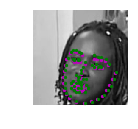

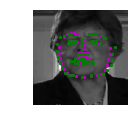

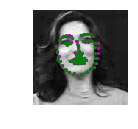

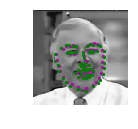

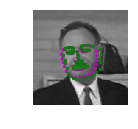

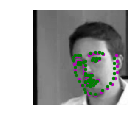

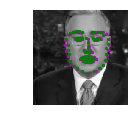

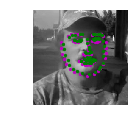

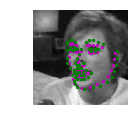

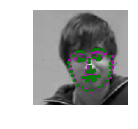

In [119]:
## TODO: visualize your test output
# you can use the same function as before, by un-commenting the line below:
if torch.cuda.is_available():
    test_images = test_images.cpu()
    test_outputs = test_outputs.cpu()
visualize_output(test_images, test_outputs, gt_pts)

Once you've found a good model (or two), save your model so you can load it and use it later!

Save your models but please **delete any checkpoints and saved models before you submit your project** otherwise your workspace may be too large to submit.

In [121]:
## TODO: change the name to something uniqe for each new model
model_dir = 'saved_models/'
model_name = 'keypoints_model_1.pt'

# after training, save your model parameters in the dir 'saved_models'
torch.save(net.state_dict(), model_dir+model_name)

After you've trained a well-performing model, answer the following questions so that we have some insight into your training and architecture selection process. Answering all questions is required to pass this project.

### Question 1: What optimization and loss functions did you choose and why?


**Answer**: ADAM and MSE, initially tried with SGD then switched to ADAM. Observed SGD is more fluctuating in loss. Loss function MSE is chosen becuase ground truth is landmark points, MSE or RMSE provide measure of euclidian distance from actual to predicted.

### Question 2: What kind of network architecture did you start with and how did it change as you tried different architectures? Did you decide to add more convolutional layers or any layers to avoid overfitting the data?

**Answer**: I started with simple network architecture with 3 conv layers and one fc layer, with that architecture loss is saturated to ~0.1 which indicates the capacity of network is not sufficient. Then increased number of conv layers, which decrease loss to 3rd decimal. I futher deepen the architecture by increasing conv layers and also which helped in reducing weights for Fc layers

### Question 3: How did you decide on the number of epochs and batch_size to train your model?

**Answer**: Initially tried with batch_size of 10 (default) given. The loss was fluctuating with small batch size, so i increased batch size to 32 and 64 and observed less fluctuations in loss. Also batch size is function of GPU memory available too. For the deep architecture 32 batch size i could afford atmost. Initally started with small epochs where the loss has still decreasing  trend, so i increased number of epochs

## Feature Visualization

Sometimes, neural networks are thought of as a black box, given some input, they learn to produce some output. CNN's are actually learning to recognize a variety of spatial patterns and you can visualize what each convolutional layer has been trained to recognize by looking at the weights that make up each convolutional kernel and applying those one at a time to a sample image. This technique is called feature visualization and it's useful for understanding the inner workings of a CNN.

In the cell below, you can see how to extract a single filter (by index) from your first convolutional layer. The filter should appear as a grayscale grid.

[[ 0.22600329  0.14913575  0.15132844]
 [ 0.12239608  0.19676979  0.19768444]
 [-0.26523697 -0.19694263 -0.02957055]]
(3, 3)


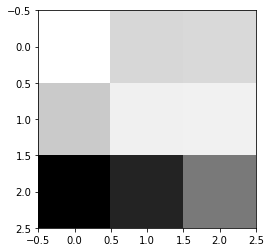

In [123]:
# Get the weights in the first conv layer, "conv1"
# if necessary, change this to reflect the name of your first conv layer
weights1 = net.cpu().conv1.weight.data

w = weights1.numpy()

filter_index = 0

print(w[filter_index][0])
print(w[filter_index][0].shape)

# display the filter weights
plt.imshow(w[filter_index][0], cmap='gray')


## Feature maps

Each CNN has at least one convolutional layer that is composed of stacked filters (also known as convolutional kernels). As a CNN trains, it learns what weights to include in it's convolutional kernels and when these kernels are applied to some input image, they produce a set of **feature maps**. So, feature maps are just sets of filtered images; they are the images produced by applying a convolutional kernel to an input image. These maps show us the features that the different layers of the neural network learn to extract. For example, you might imagine a convolutional kernel that detects the vertical edges of a face or another one that detects the corners of eyes. You can see what kind of features each of these kernels detects by applying them to an image. One such example is shown below; from the way it brings out the lines in an the image, you might characterize this as an edge detection filter.

<img src='images/feature_map_ex.png' width=50% height=50%/>


Next, choose a test image and filter it with one of the convolutional kernels in your trained CNN; look at the filtered output to get an idea what that particular kernel detects.

### TODO: Filter an image to see the effect of a convolutional kernel
---

32


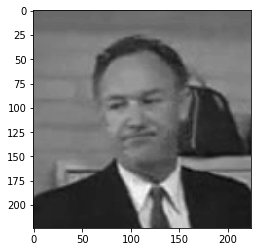

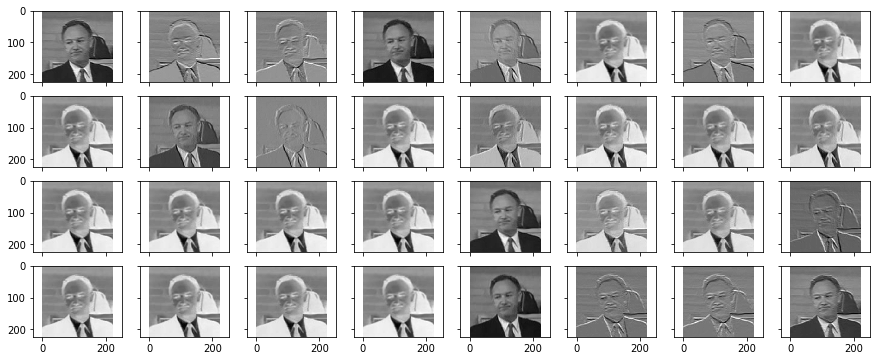

In [137]:
##TODO: load in and display any image from the transformed test dataset
# un-transform the image data
image = test_images[4].data   # get the image from it's Variable wrapper
image = image.numpy()   # convert to numpy array from a Tensor
image = np.transpose(image, (1, 2, 0))   # transpose to go from torch to numpy image
plt.imshow(np.squeeze(image), cmap='gray')

import cv2
## TODO: Using cv's filter2D function,
## apply a specific set of filter weights (like the one displayed above) to the test image
weights1 = net.cpu().conv1.weight.data
w = weights1.numpy()
fig, axes = plt.subplots(nrows=4, ncols=8, sharex=True, sharey=True, figsize=(15,6))
for filter_index in range(w.shape[0]):
    imgOut = cv2.filter2D(image, -1, w[filter_index][0])
    r = int (filter_index / 8)
    c = filter_index % 8
    axes[r, c].imshow(imgOut, cmap='gray')

### Question 4: Choose one filter from your trained CNN and apply it to a test image; what purpose do you think it plays? What kind of feature do you think it detects?


**Answer**: (does it detect vertical lines or does it blur out noise, etc.) Plotted 32 features maps of first layer above. some filters detect horizontal and vertical edges (example 2nd row fist coloum picture identifies edges in background), (2,3) feature map smoothens background, (1,2), (1,3) detects horizontal edges dominantly

---
## Moving on!

Now that you've defined and trained your model (and saved the best model), you are ready to move on to the last notebook, which combines a face detector with your saved model to create a facial keypoint detection system that can predict the keypoints on *any* face in an image!